In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tlo import Date
from tlo.analysis.utils import (
    extract_results,
    summarize,
)
import matplotlib.dates as mdates

import geopandas as gpd

In [2]:
results_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

output_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

In [3]:
climate_sensitivity_analysis = False
main_text = False
parameter_uncertainty_analysis = True

if parameter_uncertainty_analysis:
    scenario_names = range(0,  200, 1)
    scenarios_of_interest = scenario_names
    suffix = "parameter_UA"
if main_text:
    scenario_names = [
        "Baseline",
        "Best Case",
        "Worst Case"
    ]
    suffix = "main_text"
    scenarios_of_interest = [0, 1]#, 2]


In [4]:

min_year = 2025
max_year = 2031
spacing_of_years = 1


Helper functions

In [5]:
target_year_sequence = range(min_year, max_year, spacing_of_years)

# Define the extraction functions (add these near your other helper functions)
def get_num_treatments_total_delayed(_df):
    """Count total number of delayed HSI events"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    print(_df)
    return pd.Series(len(_df), name="total")

def get_num_treatments_total_cancelled(_df):
    """Count total number of cancelled HSI events"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    return pd.Series(len(_df), name="total")

def get_num_treatments_total(_df):
    """Sum all treatment counts"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    total = {}
    for d in _df["hsi_event_key_to_counts"]:
        for k, v in d.items():
            total[k] = total.get(k, 0) + v
    print(sum(total.values()))
    return pd.Series(sum(total.values()), name="total")

def get_num_dalys_total(_df):
        """Return total number of DALYS (Stacked) by label (total by age-group within the TARGET_PERIOD)
        """
        return pd.Series(_df \
            .loc[_df.year.between(*[i.year for i in TARGET_PERIOD])] \
            .drop(columns=['date', 'sex', 'age_range', 'year']) \
            .sum().sum(), name="total")

def get_num_dalys_by_month(_df):
    """Sum all DALYs across all causes by month for the target year"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    # Sum across all disease columns (excluding non-disease columns)
    disease_columns = [col for col in _df.columns
                      if col not in ['age_range', 'month', 'sex', 'year', 'date']]

    # Group by month and sum
    monthly_dalys = _df.groupby('month')[disease_columns].sum().sum(axis=1)

    return monthly_dalys

def get_population_for_year(_df):
        """Returns the population in the year of interest"""
        _df["date"] = pd.to_datetime(_df["date"])

        # Filter the DataFrame based on the target period
        filtered_df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
        numeric_df = filtered_df.drop(columns=["female", "male"], errors="ignore")
        population_sum = numeric_df.sum(numeric_only=True)

        return population_sum



 Save results

# BEST/WORST CASE


In [ ]:

results_folder_baseline = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/baseline_run_with_pop-2026-02-05T113912Z')


# Helper functions
def get_hsi_counts_by_facility_monthly(_df):
    """Get HSI counts by facility_id and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    if len(_df) == 0:
        return pd.Series(dtype=int)

    # Create keys like "2010-02_128" (month_facilityID)
    facility_month_totals = {}
    for _, row in _df.iterrows():
        month_key = row['date'].strftime('%Y-%m')
        counts_dict = row['counts']

        for key, value in counts_dict.items():
            if ':' in key:
                facility_id, _ = key.split(':', 1)
                facility_month_totals[facility_id] = facility_month_totals.get(facility_id, 0) + value

    return pd.Series(facility_month_totals)
def get_num_treatments_by_facility_delayed(_df):
    """Count number of delayed HSI events by facility"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="delayed_count")
    
    # Group by Facility_ID and count
    delayed_by_facility = _df.groupby('Facility_ID').size()
    delayed_by_facility.name = 'delayed_count'
    
    return delayed_by_facility


def get_num_treatments_by_facility_cancelled(_df):
    """Count number of cancelled HSI events by facility"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="cancelled_count")
    
    # Group by Facility_ID and count
    cancelled_by_facility = _df.groupby('Facility_ID').size()
    cancelled_by_facility.name = 'cancelled_count'
    
    return cancelled_by_facility

# Storage dictionaries
all_scenarios_appointment_delayed_mean = {}
all_scenarios_appointment_cancelled_mean = {}
all_scenarios_dalys_mean = {}
scenarios_of_interest = range(3)
# Main loop
for draw in range(len(scenarios_of_interest)):
    print(draw)
    all_years_data_delayed_mean = {}
    all_years_data_cancelled_mean = {}
    all_years_dalys_mean = {}
    baseline_hsi_by_facility = {}
    
    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by facility (sum across months to get yearly total per facility)
        hsi_by_facility = summarize(extract_results(
                    results_folder_baseline,
                    module='tlo.methods.healthsystem.summary',
                    key='hsi_event_counts_by_facility_monthly',
                    custom_generate_series=get_hsi_counts_by_facility_monthly,
                    do_scaling=False
                ), only_mean=True, collapse_columns=False)[draw]
        
        # Sum across months to get total by facility for the year
        hsi_by_facility.index = pd.Index([int(x) for x in hsi_by_facility.index], name='Facility_ID')

        baseline_hsi_by_facility[target_year] = hsi_by_facility
        # Get DALYs
        # num_dalys = summarize(extract_results(
        #     results_folder_baseline,
        #     module='tlo.methods.healthburden',
        #     key='dalys_stacked',
        #     custom_generate_series=get_num_dalys_total,
        #     do_scaling=False
        # ), only_mean=True, collapse_columns=True)

        # total_population = summarize(
        #     extract_results(
        #         results_folder_baseline,
        #         module="tlo.methods.demography",
        #         key="population",
        #         custom_generate_series=get_population_for_year,
        #         do_scaling=False,
        #     ),
        #     only_mean=True,
        #     collapse_columns=True,
        # )
        # 
        # all_years_dalys_mean[target_year] = num_dalys / total_population

        if draw in [0]:
            all_years_data_delayed_mean[target_year] = pd.Series([0], name='mean')
            all_years_data_cancelled_mean[target_year] = pd.Series([0], name='mean')
        else:
            # Get delayed counts BY FACILITY
            num_delayed_by_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,  # Update this function!
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Get cancelled counts BY FACILITY
            num_cancelled_by_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,  # Update this function!
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]


            baseline_aligned, delayed_aligned = baseline_hsi_by_facility[target_year].align(num_delayed_by_facility, fill_value=0)
            delayed_proportions = delayed_aligned / baseline_aligned
            
            baseline_aligned, cancelled_aligned = baseline_hsi_by_facility[target_year].align(num_cancelled_by_facility, fill_value=0)
            cancelled_proportions = cancelled_aligned / baseline_aligned
            
            
            all_years_data_delayed_mean[target_year] = delayed_proportions
            all_years_data_cancelled_mean[target_year] = cancelled_proportions
            
            


    all_scenarios_appointment_delayed_mean[draw] = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[draw] = all_years_data_cancelled_mean
    all_scenarios_dalys_mean[draw] = all_years_dalys_mean

0


Plots

0


/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_24677/2046511307.py:79: DtypeWarning: Columns (58,59,105,127,136,142,149,150,258,285,296,319,344,345,360,393,394,427,428,437,449,450,452,453,461,462,478,479,489,490,492,493,494,497,498,499,500,501,502,503,572,580,585,586,587,588,591,592,593,594,607,608,609,610,619,620,621,622,626,634,872,887,967,978,1066,1510) have mixed types. Specify dtype option on import or set low_memory=False.
  expanded_facility_info = pd.read_csv(


1


/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_24677/2046511307.py:79: DtypeWarning: Columns (58,59,105,127,136,142,149,150,258,285,296,319,344,345,360,393,394,427,428,437,449,450,452,453,461,462,478,479,489,490,492,493,494,497,498,499,500,501,502,503,572,580,585,586,587,588,591,592,593,594,607,608,609,610,619,620,621,622,626,634,872,887,967,978,1066,1510) have mixed types. Specify dtype option on import or set low_memory=False.
  expanded_facility_info = pd.read_csv(


KeyboardInterrupt: 

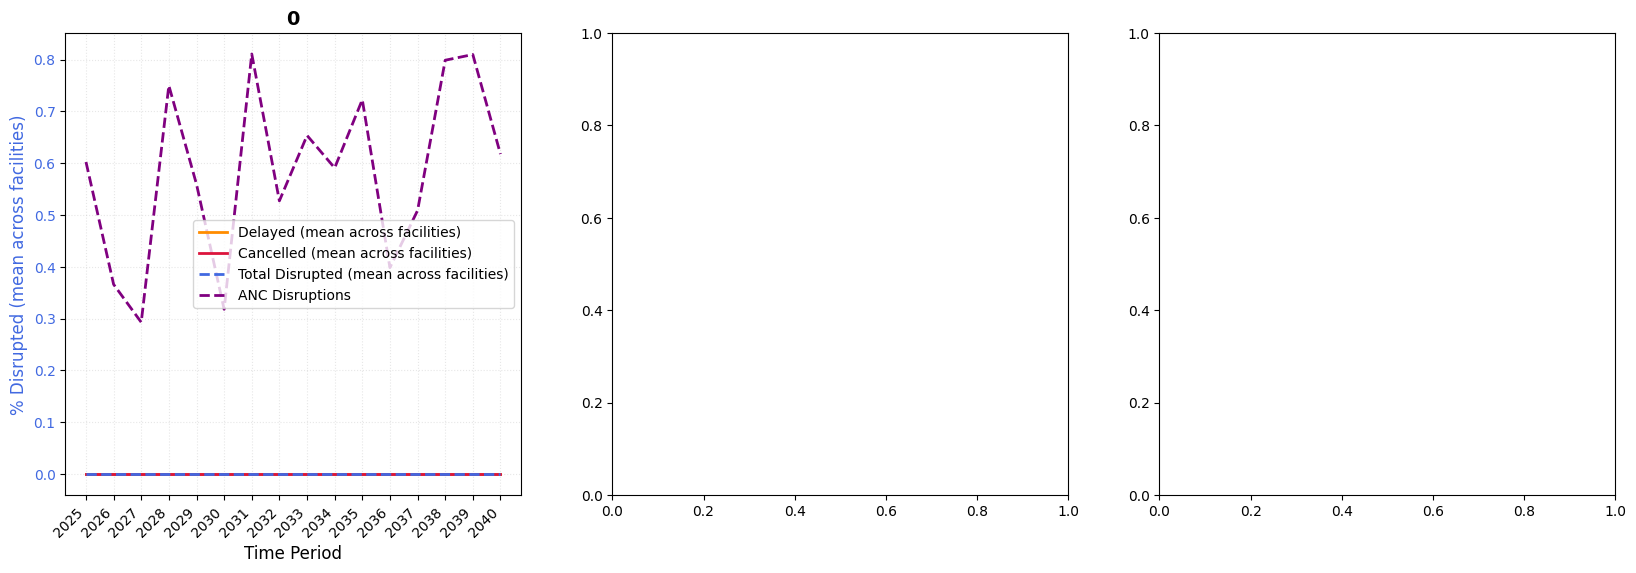

In [117]:
# Now create the plots with dual y-axes
appointment_delayed_scenarios = {}
appointment_cancelled_scenarios = {}
daly_scenarios = {}

for draw in range(len(scenarios_of_interest)):

    delayed_by_scenario = all_scenarios_appointment_delayed_mean[draw]
    cancelled_by_scenario = all_scenarios_appointment_cancelled_mean[draw]
    daly_by_scenario = all_scenarios_dalys_mean[draw]

    # Now values are Series (by facility), so aggregate across facilities
    # Option 1: Mean proportion across facilities
    delayed_all_years = [delayed_by_scenario[year].mean() if isinstance(delayed_by_scenario[year], pd.Series) else delayed_by_scenario[year] 
                         for year in sorted(delayed_by_scenario.keys())]
    cancelled_all_years = [cancelled_by_scenario[year].mean() if isinstance(cancelled_by_scenario[year], pd.Series) else cancelled_by_scenario[year]
                           for year in sorted(cancelled_by_scenario.keys())]


    appointment_delayed_scenarios[draw] = delayed_all_years
    appointment_cancelled_scenarios[draw] = cancelled_all_years

scenario_names_filtered = list(appointment_delayed_scenarios.keys())

n_scenarios = len(scenario_names_filtered)
n_cols = min(3, n_scenarios)
n_rows = (n_scenarios + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_scenarios == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for i, draw in enumerate(scenarios_of_interest):
    print(draw)
    ax1 = axes[i]

    delayed_data = np.array(appointment_delayed_scenarios[draw], dtype=float) * 100
    cancelled_data = np.array(appointment_cancelled_scenarios[draw], dtype=float) * 100
    total_data = delayed_data + cancelled_data

    # Get the years from your data
    years = sorted(all_scenarios_appointment_delayed_mean[draw].keys())
    start_date = pd.to_datetime([f'{y}-01-01' for y in years])
    
    # Add in precip and ANC data
        
        # === Load precipitation data ===
    ssp = "ssp245"
    model = "mean"
    service = "ANC"
    # Get the unique RealFacility_IDs from both dataframes' indices
    # Get all unique RealFacility_IDs from all scenarios in delayed_by_scenario
    facilities_in_delayed = set()
    for scenario_df in delayed_by_scenario.values():
        facilities_in_delayed.update(scenario_df.index.unique())
    
    # Get all unique RealFacility_IDs from all scenarios in cancelled_by_scenario
    facilities_in_cancelled = set()
    for scenario_df in cancelled_by_scenario.values():
        facilities_in_cancelled.update(scenario_df.index.unique())
    
    # Get the intersection (facilities in both)
    facilities_in_either = facilities_in_delayed.union(facilities_in_cancelled)
    
# Subset the ANC dataframe
    # weather_data = pd.read_csv(
    #     f"//Users/rem76/Desktop/ssp245"
    #     f"Downscaled_CMIP6_data_CIL/{ssp}/{model}_monthly_prediction_weather_by_facility_{service}.csv"
    # )
    
    # === Load ANC disruption resource file ===
    anc_disruption_df = pd.read_csv(
        f"/Users/rem76/PycharmProjects/TLOmodel/resources/climate_change_impacts/"
        f"ResourceFile_Precipitation_Disruptions_{ssp}_{model}.csv"
    )

    expanded_facility_info = pd.read_csv(
        f"/Users/rem76/PycharmProjects/TLOmodel/resources/climate_change_impacts/"
        f"facilities_with_lat_long_region.csv"
    )
    expanded_facility_info = expanded_facility_info.drop_duplicates(subset='Fname', keep='first')

    # Define facility level mapping
    facility_levels_types = {
        "level_0": [
            "Health Post",
            "Village Health Committee",
            "Community Health Station",
            "Village Clinic",
            "Mobile Clinic",
            "Outreach Clinic",
        ],
        "level_1a": [
            "Dispensary",
            "Rural Health Centre",
            "Urban Health Centre",
            "Private Clinic",
            "Special Clinic",
            "Antenatal Clinic",
            "Maternity Clinic",
            "Maternity Facility",
        ],
        "level_1b": ["Community Hospital", "Rural Hospital", "CHAM Hospital"],
        "level_2": ["District Hospital", "District Health Office"],
        "level_3": [
            "Kamuzu Central Hospital",
            "Mzuzu Central Hospital",
            "Zomba Central Hospital",
            "Queen Elizabeth Central Hospital",
        ],
        "level_4": ["Zomba Mental Hospital"],
    }
    
    # Create reverse lookup: FType -> Level
    ftype_to_level = {}
    for level, ftypes in facility_levels_types.items():
        for ftype in ftypes:
            ftype_to_level[ftype] = level
    
    # Create a lookup dictionary from facility name to district and ftype
    facility_lookup = expanded_facility_info.set_index('Fname')[['Dist', 'Ftype']].to_dict('index')
    
    # Function to get district and ftype for a facility
    def get_facility_info(facility_id):
        """Get district and facility type for a given facility ID"""
        facility_name = str(facility_id)
        
        if facility_name in facility_lookup:
            return facility_lookup[facility_name]['Dist'], facility_lookup[facility_name]['Ftype']
        else:
            return None, None
    
    # Add district and ftype columns to anc_disruption_df
    anc_disruption_df[['District', 'Ftype']] = anc_disruption_df['RealFacility_ID'].apply(
        lambda x: pd.Series(get_facility_info(x))
    )
    
    # Add facility level
    anc_disruption_df['Level'] = anc_disruption_df['Ftype'].map(ftype_to_level)
    
    # Filter ANC disruption data to match simulation period
    anc_disruption_df = anc_disruption_df[
        (anc_disruption_df["year"] >= start_year) &
        (anc_disruption_df["year"] <= end_year)
    ]
    
    # Now you can group by district and level (or ftype)
    # Option 1: Group by district and level
    avg_by_district_level = anc_disruption_df.groupby(
        ["year", "District", "Level"], as_index=False
    )["mean_all_service"].mean()

    # Get simulation date range
    start_year = min_year
    start_month = 1
    end_year = max_year
    end_month = 12
    
    # Filter ANC disruption data to match simulation period
    anc_disruption_df = anc_disruption_df[
        ((anc_disruption_df["year"] == start_year) & (anc_disruption_df["month"] >= start_month)) |
        ((anc_disruption_df["year"] > start_year) & (anc_disruption_df["year"] < end_year)) |
        ((anc_disruption_df["year"] == end_year) & (anc_disruption_df["month"] <= end_month))
    ]
    
    # Alternative simpler filter if years are contiguous:
    anc_disruption_df = anc_disruption_df[
        (anc_disruption_df["year"] >= start_year) &
        (anc_disruption_df["year"] <= end_year)
    ]

    avg_df = anc_disruption_df.groupby(["year"], as_index=False)["mean_all_service"].mean()
    avg_df = avg_df.sort_values(["year"])  # Ensure sorted
    anc_disruption_values = avg_df["mean_all_service"].values * 100
    
    
    # Plot appointment disruptions on primary y-axis
    line1 = ax1.plot(start_date, delayed_data, label="Delayed (mean across facilities)", linewidth=2, color='#FF8C00')
    line2 = ax1.plot(start_date, cancelled_data, label="Cancelled (mean across facilities)", linewidth=2, color='#DC143C')
    line3 = ax1.plot(start_date, total_data, label="Total Disrupted (mean across facilities)", linewidth=2, color='#4169E1', linestyle='--')
    
    line4 = ax1.plot(start_date, anc_disruption_values, label="ANC Disruptions", linewidth=2, color='purple', linestyle='--')

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    ax1.set_xlabel("Time Period", fontsize=12)
    ax1.set_ylabel("% Disrupted (mean across facilities)", fontsize=12, color='#4169E1')
    ax1.tick_params(axis='y', labelcolor='#4169E1')
    ax1.set_title(f"{draw}", fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle=':')

    # Combine legends
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best', fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
#lt.savefig(output_folder / f"delayed_cancelled_dalys.png", dpi=300, bbox_inches='tight')
plt.show()

In [94]:
anc_disruption_df

,Unnamed: 0,RealFacility_ID,year,month,service,disruption,mean_all_service
0,0,Area 30 Police Clinic,2025,1,all,0.047927,0.047927
1,1,Balaka District Hospital,2025,1,all,0.063890,0.063890
2,2,Bangwe Health Centre,2025,1,all,0.000000,0.000000
3,3,Benga Health Centre,2025,1,all,0.000000,0.000000
4,4,Bilira Health Centre,2025,1,all,0.000000,0.000000
...,...,...,...,...,...,...,...
62971,62971,Usisya Health Centre,2040,12,all,0.008620,0.008620
62972,62972,Utale 1 Health Centre,2040,12,all,0.000000,0.000000
62973,62973,Utale 2 Health Centre,2040,12,all,0.000000,0.000000
62974,62974,Wiliro Health Centre,2040,12,all,0.000000,0.000000


Add in months

In [113]:
results_folder_baseline = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/baseline_run_with_pop-2026-02-05T113912Z')


# Helper functions
def get_hsi_counts_by_facility_monthly(_df):
    """Get HSI counts by facility_id and month - returns with month as part of index"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    if len(_df) == 0:
        return pd.Series(dtype=int)

    # Create keys like "2010-01_128" (YYYY-MM_facilityID)
    facility_month_totals = {}
    for _, row in _df.iterrows():
        month_key = row['date'].strftime('%Y-%m')
        counts_dict = row['counts']

        for key, value in counts_dict.items():
            if ':' in key:
                facility_id, _ = key.split(':', 1)
                combined_key = f"{month_key}_{facility_id}"
                facility_month_totals[combined_key] = facility_month_totals.get(combined_key, 0) + value

    return pd.Series(facility_month_totals)


def get_num_treatments_by_facility_delayed(_df):
    """Count number of delayed HSI events by facility and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="delayed_count")
    
    # Extract month from date
    _df['month'] = _df['date'].dt.strftime('%Y-%m')
    
    # Create combined key: month_facilityID
    _df['month_facility'] = _df['month'] + '_' + _df['Facility_ID'].astype(str)
    
    # Group by month_facility and count
    delayed_by_month_facility = _df.groupby('month_facility').size()
    delayed_by_month_facility.name = 'delayed_count'
    
    return delayed_by_month_facility


def get_num_treatments_by_facility_cancelled(_df):
    """Count number of cancelled HSI events by facility and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="cancelled_count")
    
    # Extract month from date
    _df['month'] = _df['date'].dt.strftime('%Y-%m')
    
    # Create combined key: month_facilityID
    _df['month_facility'] = _df['month'] + '_' + _df['Facility_ID'].astype(str)
    
    # Group by month_facility and count
    cancelled_by_month_facility = _df.groupby('month_facility').size()
    cancelled_by_month_facility.name = 'cancelled_count'
    
    return cancelled_by_month_facility


# Storage dictionaries
all_scenarios_appointment_delayed_mean = {}
all_scenarios_appointment_cancelled_mean = {}
all_scenarios_dalys_mean = {}
scenarios_of_interest = range(3)

# Main loop
for draw in range(len(scenarios_of_interest)):
    print(draw)
    all_years_data_delayed_mean = {}
    all_years_data_cancelled_mean = {}
    all_years_dalys_mean = {}
    baseline_hsi_by_month_facility = {}
    
    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by month and facility (format: "YYYY-MM_facilityID")
        hsi_by_month_facility = summarize(extract_results(
            results_folder_baseline,
            module='tlo.methods.healthsystem.summary',
            key='hsi_event_counts_by_facility_monthly',
            custom_generate_series=get_hsi_counts_by_facility_monthly,
            do_scaling=False
        ), only_mean=True, collapse_columns=False)[draw]

        baseline_hsi_by_month_facility[target_year] = hsi_by_month_facility

        if draw in [0]:
            all_years_data_delayed_mean[target_year] = pd.Series([0], name='mean')
            all_years_data_cancelled_mean[target_year] = pd.Series([0], name='mean')
        else:
            # Get delayed counts BY MONTH AND FACILITY
            num_delayed_by_month_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Get cancelled counts BY MONTH AND FACILITY
            num_cancelled_by_month_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Align and calculate proportions at month-facility level
            baseline_aligned, delayed_aligned = baseline_hsi_by_month_facility[target_year].align(
                num_delayed_by_month_facility, fill_value=0
            )
            delayed_proportions = delayed_aligned / baseline_aligned
            
            baseline_aligned, cancelled_aligned = baseline_hsi_by_month_facility[target_year].align(
                num_cancelled_by_month_facility, fill_value=0
            )
            cancelled_proportions = cancelled_aligned / baseline_aligned
            
            all_years_data_delayed_mean[target_year] = delayed_proportions
            all_years_data_cancelled_mean[target_year] = cancelled_proportions

    all_scenarios_appointment_delayed_mean[draw] = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[draw] = all_years_data_cancelled_mean
    all_scenarios_dalys_mean[draw] = all_years_dalys_mean

0


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

1


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_24677/917255231.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['month'] = _df['date'].dt.strftime('%Y-%m')
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_24677/917255231.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

2


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_24677/917255231.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['month'] = _df['date'].dt.strftime('%Y-%m')
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_24677/917255231.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [ ]:
ssps = ["ssp245"]
index_name = ["SSP 2.45 Mean"]
model_type = "mean"  # only the middle panel
service = "ANC"

for ssp_scenario in ssps:
    fig, ax = plt.subplots(figsize=(12, 6))  # single panel

    # Load weather data
    weather_data_prediction_monthly = pd.read_csv(
        f"/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Downscaled_CMIP6_data_CIL/{ssp_scenario}/{model_type}_monthly_prediction_weather_by_facility_{service}.csv",
        dtype={'column_name': 'float64'}
    )

    # Subset relevant months (12 months of 2024 through first months of 2029, or adjust as needed)
    mask = (weather_data_prediction_monthly.index > 11) & \
           (weather_data_prediction_monthly.index < (17*12))
    weather_data_prediction_monthly = weather_data_prediction_monthly.loc[mask].reset_index(drop=True)

    # Average across facilities (monthly)
    weather_data_avg = weather_data_prediction_monthly.iloc[:, 1:].mean(axis=1)

    # Load appointment disruption data
    scenario_name = "SSP 2.45 Mean"

    # Get the monthly data dictionaries
    delayed_monthly = all_scenarios_appointment_delayed_mean[scenario_name]
    cancelled_monthly = all_scenarios_appointment_cancelled_mean[scenario_name]

    # Convert to arrays and multiply by 100 for percentage
    # Sort by month key to ensure correct order
    month_keys = sorted(delayed_monthly.keys())
    delayed_data = np.array([delayed_monthly[key].values[0] for key in month_keys]) * 100
    cancelled_data = np.array([cancelled_monthly[key].values[0] for key in month_keys]) * 100
    total_data = delayed_data + cancelled_data

    # Create date range for x-axis
    n_months = len(delayed_data)
    start_date = pd.date_range(start='2025-01', periods=n_months, freq='M')

    # Ensure weather data matches the length of appointment data
    if len(weather_data_avg) != n_months:
        print(f"Warning: Weather data length ({len(weather_data_avg)}) doesn't match appointment data ({n_months})")
        # Truncate or pad as needed
        min_len = min(len(weather_data_avg), n_months)
        weather_data_avg = weather_data_avg[:min_len]
        delayed_data = delayed_data[:min_len]
        cancelled_data = cancelled_data[:min_len]
        total_data = total_data[:min_len]
        start_date = start_date[:min_len]

    # Plot precipitation on primary y-axis
    color_precip = '#9AC4F8'
    ax.plot(start_date, weather_data_avg, label='Monthly Precipitation', color=color_precip,
            linewidth=2, linestyle='--')
    ax.set_xlabel("Month")
    ax.set_ylabel("Monthly Precipitation (mm)", color=color_precip)
    ax.tick_params(axis='y', labelcolor=color_precip)
    ax.grid(False)

    ax.set_xlim(left=datetime(2025, 1, 1))

    # Or if you want to set both start and end:
    # ax.set_xlim(datetime(2025, 1, 1), datetime(2030, 12, 31))

    # Format the x-axis date labels
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # Secondary y-axis for appointment disruptions
    ax2 = ax.twinx()
    ax2.plot(start_date, delayed_data, label="Delayed", linewidth=2, color='#FEB95F')
    ax2.plot(start_date, cancelled_data, label="Cancelled", linewidth=2, color='#f07167')
    ax2.plot(start_date, total_data, label="Total Disrupted", linewidth=2, color='#5A716A')
    ax2.set_ylabel("Appointment Disruption (%)", rotation=-90, labelpad=25)
    ax2.tick_params(axis='y')

    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False)
    ax.text(-0.0, 1.05, '(C)', transform=ax.transAxes,
            fontsize=14, va='top', ha='right')
    plt.tight_layout()
    plt.show()